# Pipeline Testing

In [1]:
#
import os
import numpy as np
import pandas as pd
from pandas import Timestamp
import seaborn as sns
import matplotlib.pyplot as plt

#
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
import datetime
import pytz
from zipline.data.bundles import load
from trading_calendars import get_calendar
import pyfolio as pf
#
%load_ext zipline

## Check Symbols of Bundle

In [6]:
trading_calendar=get_calendar('Crypto')

now = Timestamp.utcnow()
bundle = load('NFTU', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))

print(symbols)

{'ADA', 'TFUEL', 'MATIC', 'SOL', 'AVAX', 'MANA', 'FLOW'}


## Simple Strategy

In [3]:
selected_coin = 'ADA'
shortest_period = 7
longest_period = 14
holding_period = 2

def initialize(context):
    context.i = 0
    context.holding_days = 0
    context.bought = False
    set_benchmark(symbol(selected_coin))
    context.asset = symbol(selected_coin)

def handle_data(context, data):
    # skip days for moving average
    context.i += 1
    if context.i < longest_period:
        return
    if context.bought:
        context.holding_days += 1
        
    # trading algorithm
    short_ma = data.history(context.asset, 'close', bar_count=shortest_period, frequency='1d').mean()
    long_ma = data.history(context.asset, 'close', bar_count=longest_period, frequency='1d').mean()

    open_orders = get_open_orders()
    
    # buy signal
    if context.asset not in open_orders:
        if short_ma > long_ma and context.holding_days == 0 and not context.bought:
            order_target_percent(context.asset, 1.0)
            context.bought = True
        
    # sell signal
    if (short_ma < long_ma or context.holding_days == holding_period) and context.bought:
        order_target_percent(context.asset, 0.0)
        context.holding_days = 0
        context.bought = False

    # record price
    record(close=data.current(symbol(selected_coin), 'close'),
          short_ma=short_ma,
          long_ma=long_ma)

In [5]:
# date range MUST BE pd.Timestamp
start_date = pd.Timestamp('2017-11-09', tz='utc')
end_date = pd.Timestamp('2022-04-11', tz='utc')

# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('Crypto'),
                            initialize=initialize,
                            capital_base=1000,
                            handle_data=handle_data,
                            bundle='NFTU',
                            data_frequency='daily')
perf.head()
perf.tail()

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,period_open,period_close,net_leverage,starting_exposure,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,portfolio_value,...,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,algorithm_period_return,close,short_ma,long_ma
2022-04-07 23:59:00+00:00,2022-04-07 00:00:00+00:00,2022-04-07 23:59:00+00:00,0.0,0.0,0.0,0.0,0.0,17.710942,17.710942,17.710942,...,0.0,1611,2022-04,0.926982,42.68,1.252343,-0.982289,1.092,1.148000,1.154286
2022-04-08 23:59:00+00:00,2022-04-08 00:00:00+00:00,2022-04-08 23:59:00+00:00,0.0,0.0,0.0,0.0,0.0,17.710942,17.710942,17.710942,...,0.0,1612,2022-04,0.926694,40.04,1.252222,-0.982289,1.026,1.128143,1.149143
2022-04-09 23:59:00+00:00,2022-04-09 00:00:00+00:00,2022-04-09 23:59:00+00:00,0.0,0.0,0.0,0.0,0.0,17.710942,17.710942,17.710942,...,0.0,1613,2022-04,0.926407,40.80,1.251845,-0.982289,1.045,1.112286,1.141571
2022-04-10 23:59:00+00:00,2022-04-10 00:00:00+00:00,2022-04-10 23:59:00+00:00,0.0,0.0,0.0,0.0,0.0,17.710942,17.710942,17.710942,...,0.0,1614,2022-04,0.926120,40.24,1.251478,-0.982289,1.031,1.090143,1.130786
2022-04-11 23:59:00+00:00,2022-04-11 00:00:00+00:00,2022-04-11 23:59:00+00:00,0.0,0.0,0.0,0.0,0.0,17.710942,17.710942,17.710942,...,0.0,1615,2022-04,0.925833,36.36,1.251701,-0.982289,0.934,1.050286,1.113929


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,99.89,2018-01-03,2022-04-06,NaT,NaN
1,23.31,2017-12-04,2017-12-11,2017-12-16,10
2,22.37,2017-12-19,2017-12-22,2017-12-29,9
3,3.49,2017-11-22,2017-11-23,2017-11-25,3
4,3.39,2017-11-25,2017-11-26,2017-11-27,1


KeyboardInterrupt: 

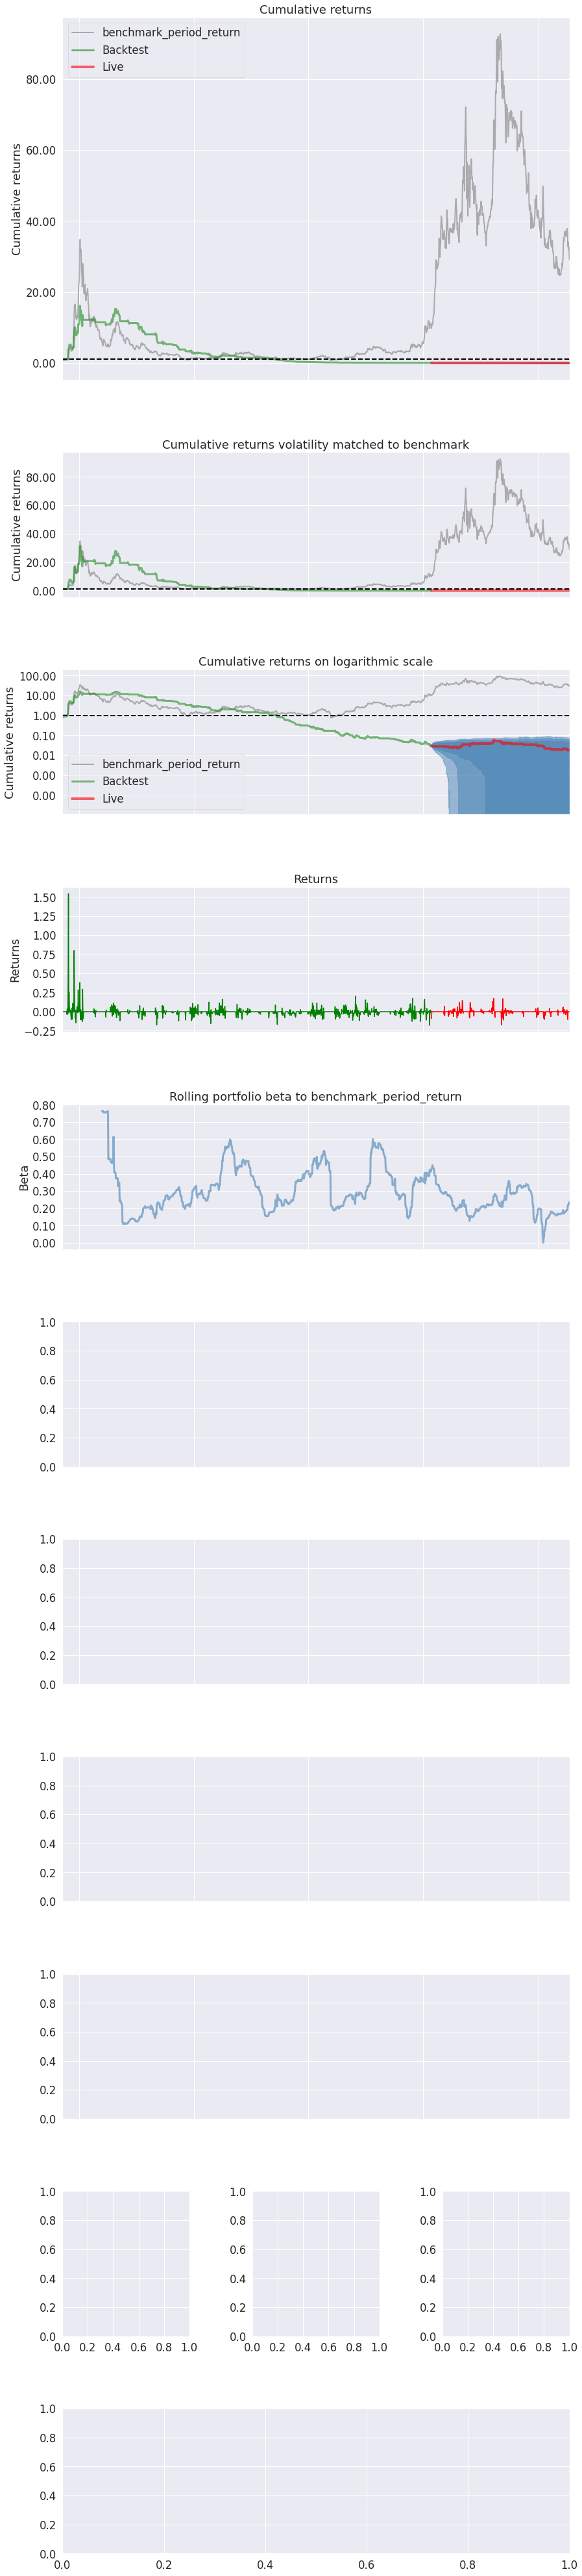

In [7]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns, live_start_date='2021-01-27')